# Clusterização de texto usando K-Means

Atividade de aprendizado sobre como usar o algoritmo de K-means, um algoritmo não supervisionado, para clusterizar as frases dadas pelo professor no dataset "dadosTextosCientificos.tsv".

# Objetivo do K-means
Agrupar pontos de dados semelhantes e descobrir padrões subjacentes. O K-means procura um número fixo de clusters, uma coleção de pontos de dados agregados devido a certas semelhanças entre si, em um conjunto de dado.



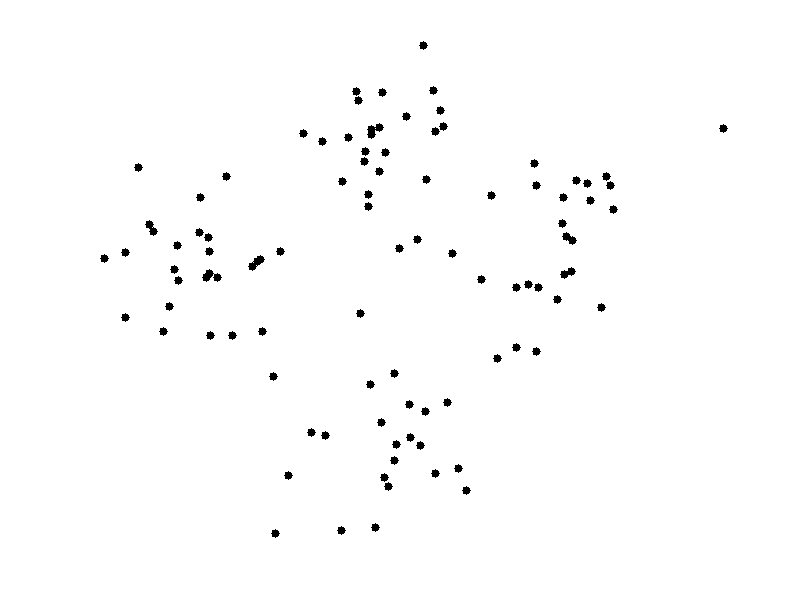
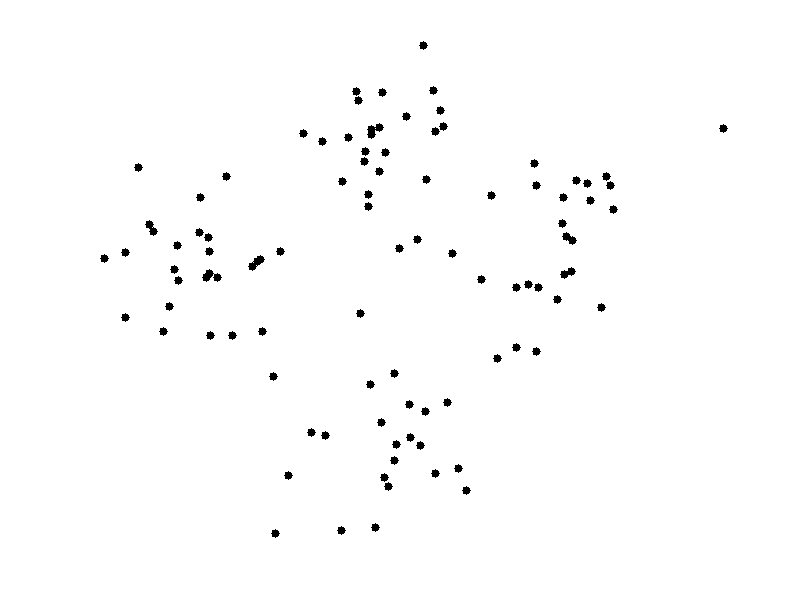
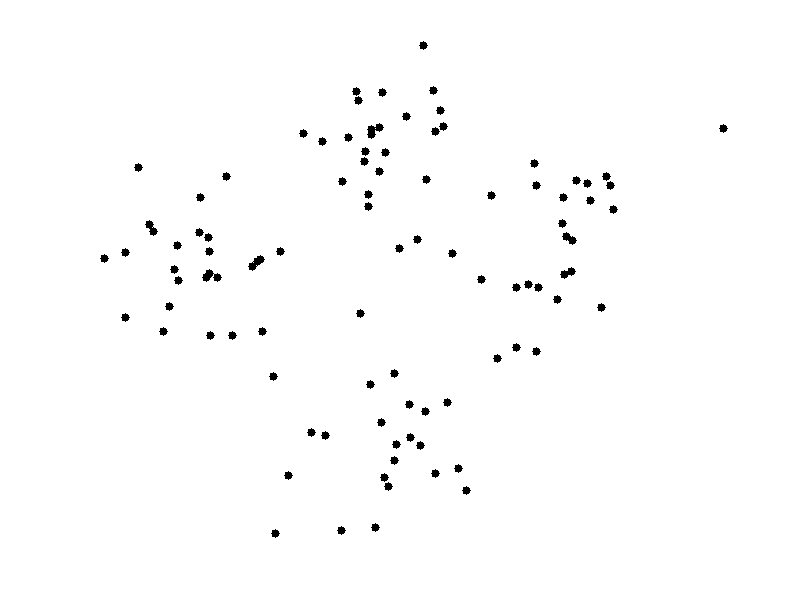
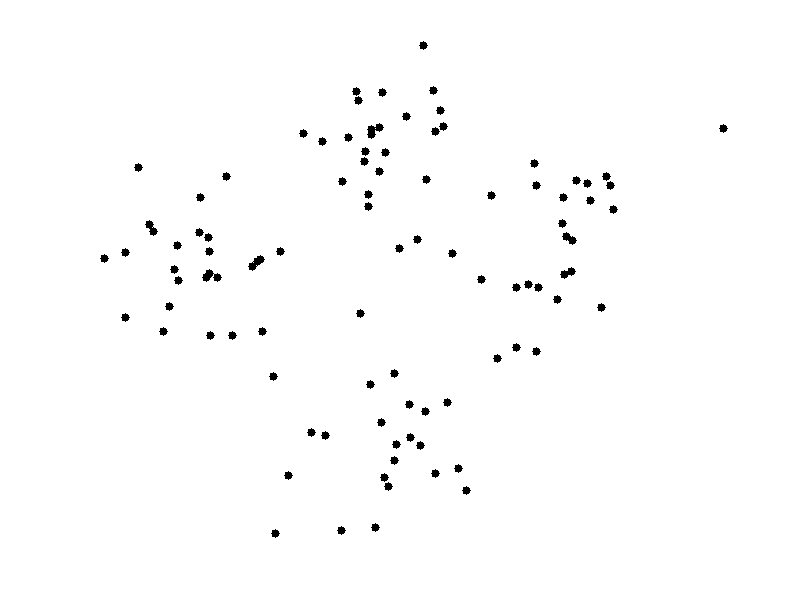

In [1]:
!pip install spacy


!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [2]:
# Estrutura de Dados
import numpy as np 
import pandas as pd 
import os
import string

# Processamento
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# K-Means
from sklearn import cluster

# Analises
import matplotlib.pyplot  as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud
from spacy import displacy

print("Bibliotecas importadas com sucesso")

# Ativar GPU e carregar pt model (se erro fazer pip install de 'pt_core_news_lg')
spacy.require_gpu()
nlp = spacy.load('pt_core_news_lg')
if spacy.prefer_gpu():
    print("\nUsando GPU")
else:
    print("\nUsando CPU")

# Carregar nosso DataSet
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('../input/dl-2024/dadosTextosCientificos.tsv',
                   sep='\t', engine='python', encoding='latin-1')

df

Bibliotecas importadas com sucesso

Usando GPU
/kaggle/input/dl-2024/dadosTextosCientificos.tsv


,Título_Público,Descricao_pública
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...
...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...


In [3]:
texto1 = df.iloc[0, 0]
print("Texto um: ", texto1)

texto2 = df.iloc[7, 0]
print("Texto dois: ", texto2)

Texto um:  Açúcar de frutas e aplicação em bolos como substituto da sacarose
Texto dois:  Desenvolvimento de molhos pesto de manjericão com castanhas do Brasil


In [4]:
def pos_tagging(texto):
    doc = nlp(texto)
    
    print("POS Tagging:")
    for token in doc:
        print(f"{token.text} - {token.pos_} ({token.tag_})")
        
def named_entities(texto):
    doc = nlp(texto)
    print("\nNamed Entities (NER):")
    for ent in doc.ents:
        print(f"{ent.text} - {ent.label_}")
    print()


pos_tagging(texto1)
named_entities(texto1)

pos_tagging(texto2)
named_entities(texto2)

POS Tagging:
Açúcar - PROPN (PROPN)
de - ADP (ADP)
frutas - NOUN (NOUN)
e - CCONJ (CCONJ)
aplicação - NOUN (NOUN)
em - ADP (ADP)
bolos - NOUN (NOUN)
como - ADP (ADP)
substituto - NOUN (NOUN)
da - ADP (ADP)
sacarose - NOUN (NOUN)

Named Entities (NER):

POS Tagging:
Desenvolvimento - NOUN (NOUN)
de - ADP (ADP)
molhos - NOUN (NOUN)
pesto - NOUN (NOUN)
de - ADP (ADP)
manjericão - NOUN (NOUN)
com - ADP (ADP)
castanhas - NOUN (NOUN)
do - ADP (ADP)
Brasil - PROPN (PROPN)

Named Entities (NER):
Brasil - LOC



In [5]:
def mostrar_arvore_dep(texto):
    doc = nlp(texto)
    displacy.render(doc, style="dep", jupyter=True)

mostrar_arvore_dep(texto1)
mostrar_arvore_dep(texto2)

In [6]:
def normalizar_texto(texto):
    if not isinstance(texto, str):  # Verifica se o texto é uma string
        return ""  # Retorna uma string vazia se não for
    
    # Preparar pontuacose e Stopwords
    pontuacoes = string.punctuation
    stopwords = list(STOP_WORDS)
    
    # Processar o texto com o spaCy
    doc = nlp(texto)
    
    # Remover stopwords e pontuação antes de lematizar
    tokens_sem_stopwords = [token for token in doc if token.text.lower() not in stopwords and token.text not in pontuacoes]
    
    # Lematizar os tokens restantes
    texto_lemmatizado = " ".join([token.lemma_ for token in tokens_sem_stopwords])
    
    return texto_lemmatizado

# texto_normalizado = normalizar_texto(texto)
# print("Texto original:", texto)
# print("\nTexto normalizado:", texto_normalizado)

# Normalizar títulos e descrições
df['Titulo_Normalizado'] = df['Título_Público'].apply(normalizar_texto)
df['Descricao_Normalizada'] = df['Descricao_pública'].apply(normalizar_texto)

# Concatenar títulos e descrições normalizados
df['Texto_Normalizado'] = df['Titulo_Normalizado'] + ' ' + df['Descricao_Normalizada']

In [7]:
# Vetorizar os textos normalizados
vetorizar = TfidfVectorizer(max_features=1000)
X = vetorizar.fit_transform(df['Texto_Normalizado'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vetorizar.get_feature_names_out())


final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

# 5 palavras mais relevantes (com os maiores valores de TF-IDF

2725 rows


,0,1,2,3,4,5,6,7,8,9,...,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724
sustentável,0.530098,0.213259,0.260005,0.251195,0.172136,0.118114,0.000000,0.0,0.0,0.190078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.093234,0.0
indústria,0.220537,0.088722,0.000000,0.000000,0.000000,0.098278,0.000000,0.0,0.0,0.052719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
pó,0.181475,0.000000,0.000000,0.000000,0.000000,0.000000,0.091333,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
produção,0.176501,0.142012,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.084384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073858,0.000000,0.0
12,0.175857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [8]:
# Normalizar os dados
X_normalizado = normalize(X)

# Aplicar K-Means
kmeans = cluster.KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_normalizado)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [9]:
# Adicionar os rótulos dos clusters ao DataFrame
df['Cluster'] = kmeans.labels_

# Avaliar a qualidade dos clusters
silhouette_avg = silhouette_score(X_normalizado, kmeans.labels_)
print(f"Coeficiente de Silhueta: {silhouette_avg}")

Coeficiente de Silhueta: 0.008290191358002923


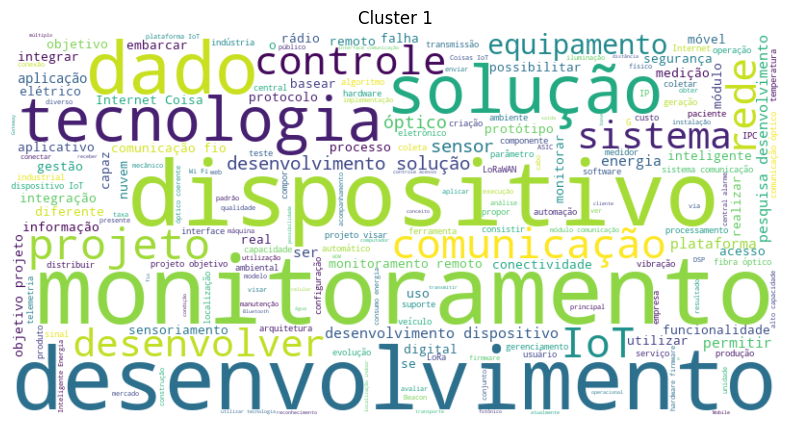

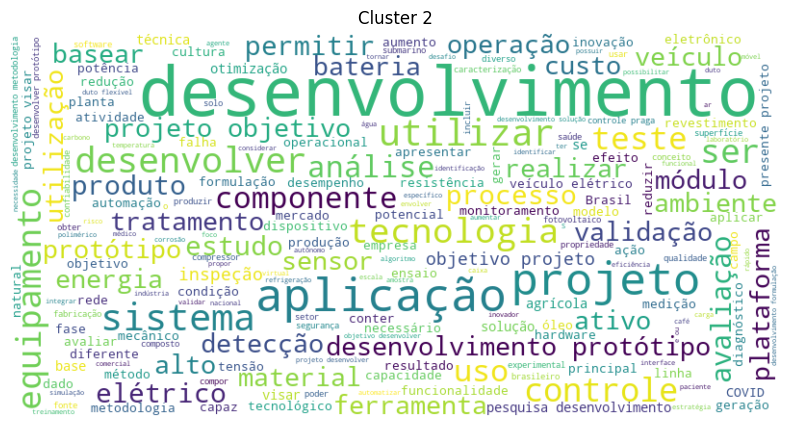

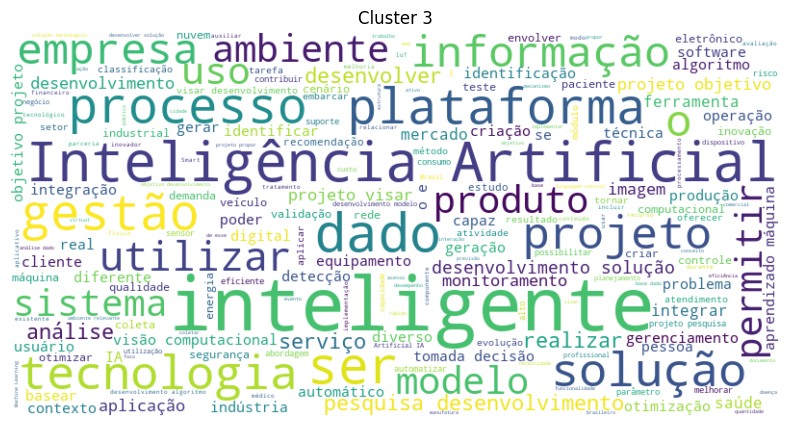

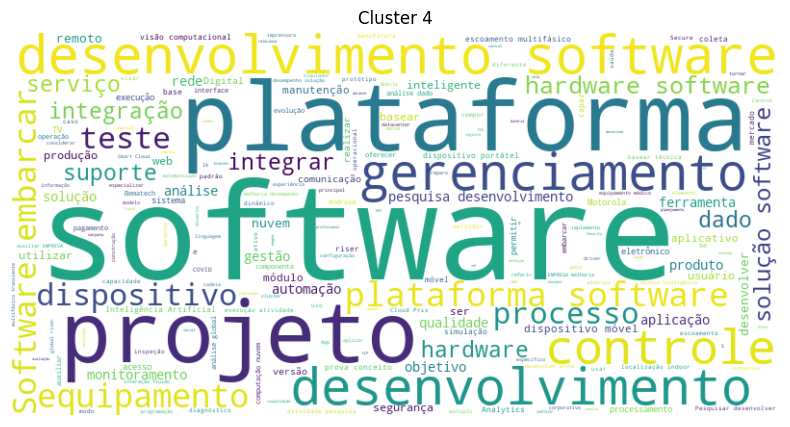

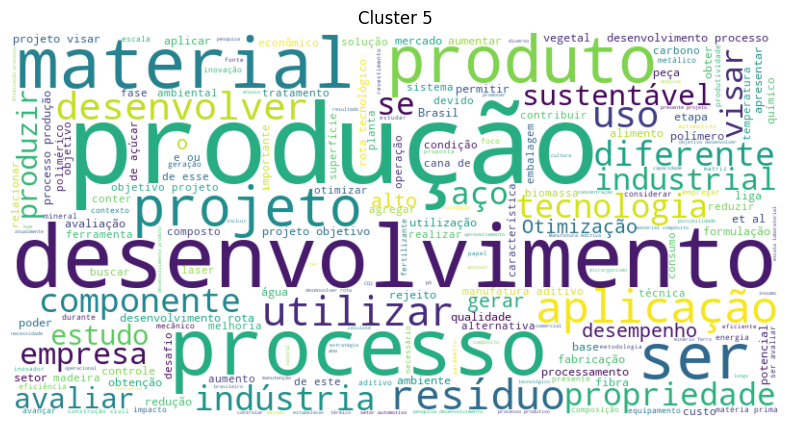

In [10]:
# Visualização dos clusters com Map of Words
for i in range(kmeans.n_clusters):
    palavras = " ".join(df[df['Cluster'] == i]['Texto_Normalizado'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(palavras)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Cluster {i + 1}')
    plt.show()

In [11]:
# Analise de CLuster
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2, max_k):
        kmeans = cluster.KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            tol=0.0001,
            random_state=1,
            algorithm='lloyd'  # Optional, the default algorithm
        )
        kmeans_results.update({k: kmeans.fit(data)})
        
    return kmeans_results

# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vetorizar.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()


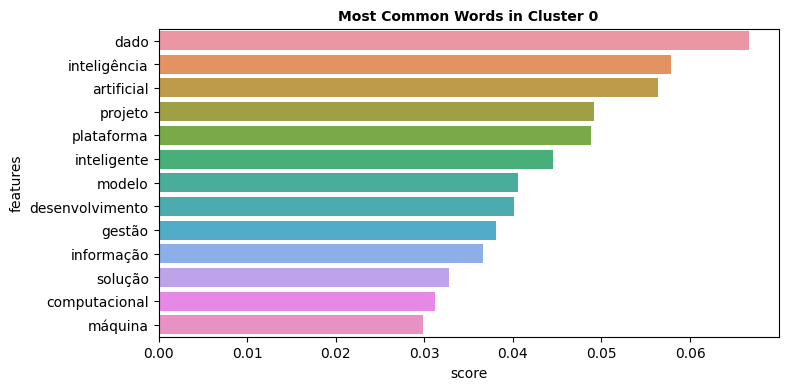

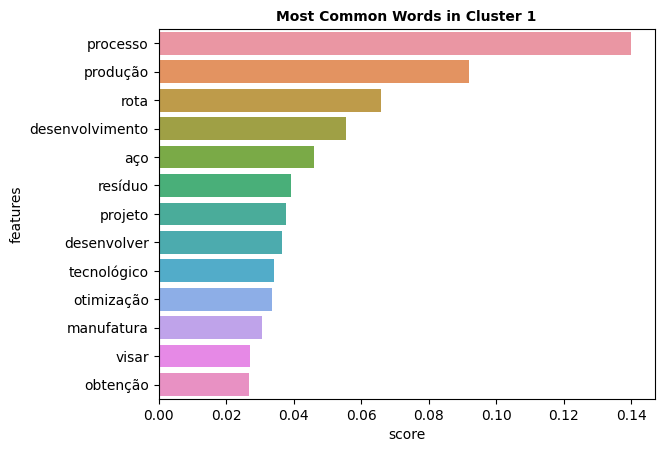

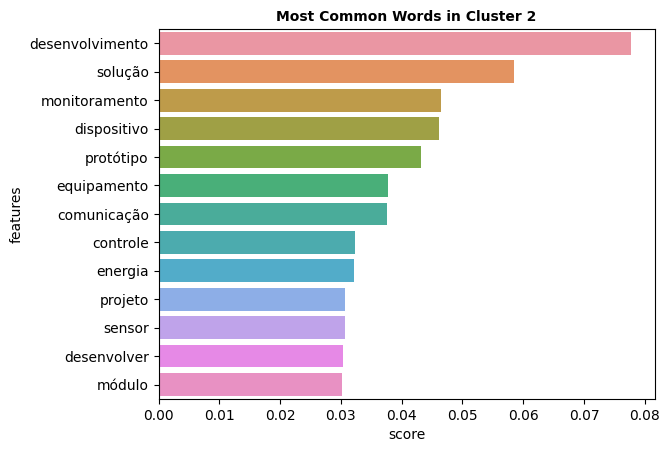

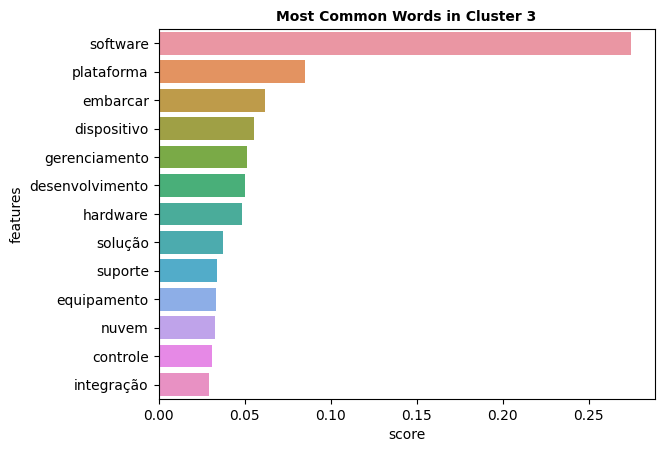

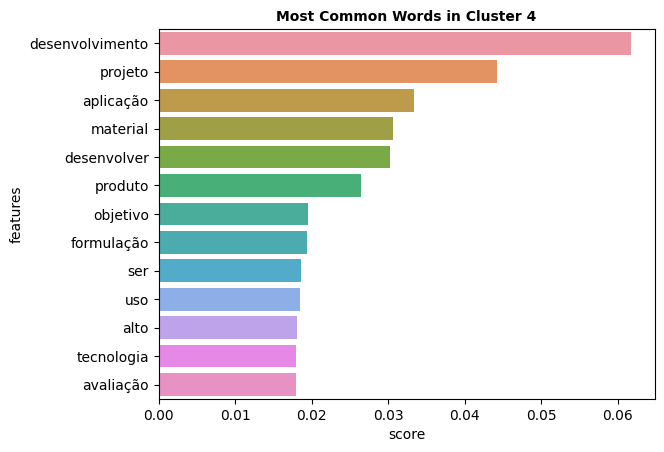

In [12]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)
